In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import statsmodels.formula.api as sm
import copy
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import sklearn
from math import sqrt
from functools import reduce
import numpy as np
#import ee
#import geemap
import geopandas as gpd
import rioxarray as rxr
import rasterstats as rs
from rasterio.plot import show
import rasterio
import cartopy.crs as ccrs
import statsmodels

%matplotlib inline
plt.rcParams["font.family"] = "Arial"

# IRRIGATED

R^2 = 0.5497
yield = 4.4402*NDVI + -5.794


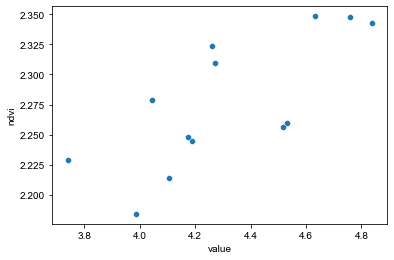

In [22]:
ndviFilePath='/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/pts_seasonalCompositeNDVI_2001-2018_SUM_JAS.gpkg'
startYr = 2012
endYr = 2017


ndvi = gpd.read_file(ndviFilePath)
ndvi = ndvi.rename(columns=dict(zip(list(ndvi.columns[3:21]), list(np.arange(2001, 2019, 1)))))
ndvi = ndvi.drop(columns=['id','geometry'])
ndvi = ndvi.melt(id_vars=["Class", "ADM3_EN"], var_name="Date", value_name='ndvi')
ndvi = ndvi[ndvi.Class=='Irrigated Rice']
ndvi = ndvi.groupby(['ADM3_EN','Date']).mean().reset_index()

ndvi

actual = pd.read_csv('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/iloilo_rice_data_cleaned_imputed_new.csv')
#actual = actual[(actual.param == 'yield') & (actual.ecosystem == 'rf')].reset_index(drop=True)
#actual = actual[(actual.year == 2018)].groupby('muni').mean().reset_index(drop=False)
#actual = actual.groupby('year').mean().reset_index()
#sns.lineplot(x='year', y='value', data=actual)

actual

merged = actual.merge(ndvi, left_on=['year','muni'], right_on=['Date','ADM3_EN'])

merged2=merged.groupby(['muni','ecosystem','value','ndvi']).mean().reset_index()
merged2

df=merged2[(merged2['ecosystem']=='irri')].reset_index(drop=True)
df=df[(df['year']<=endYr) & (df['year']>=startYr)].reset_index(drop=True)
df=df.groupby(['muni']).mean().reset_index()
df

np.random.seed(1)
df['randnum']=np.random.randint(len(df), size=len(df)).astype(float)
calibration=df[df['randnum']>=(len(df)*0.30)].reset_index(drop=True)
validation=df[df['randnum']<=(len(df)*0.30)].reset_index(drop=True)

sns.scatterplot(x='value', y='ndvi', data = calibration)

results = sm.ols(formula = 'value ~ ndvi', 
                 missing='drop',
                 data=calibration).fit()
print('R^2 = ' + str(results.rsquared.round(decimals=4)))
print('yield = ' + str(results.params[1].round(decimals=4)) + '*NDVI + ' + str(results.params[0].round(decimals=4)))
plt.show()

In [27]:
results.summary()

/Users/delatorredm/miniconda3/envs/ee/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     13.43
Date:                Fri, 17 Dec 2021   Prob (F-statistic):            0.00372
Time:                        23:12:17   Log-Likelihood:                 1.9401
No. Observations:                  13   AIC:                            0.1197
Df Residuals:                      11   BIC:                             1.250
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7940      2.758     -2.101      0.060     -11.865       0.277
ndvi           4.4402      1.212      3.665      0.004       1.773       7.107
==============================================================================
Omnibus:                        1.091   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.579   Jarque-Bera (JB):                0.781
Skew:                          -0.257   Prob(JB):                        0.677
Kurtosis:                       1.915   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
calibration=df[df['randnum']>=(len(df)*0.30)].reset_index(drop=True)

In [24]:
calibration

,muni,value,ndvi,year,Date,randnum
0,Banate,4.105603,2.214025,2014.5,2014.5,11.0
1,Barotac Nuevo,4.260785,2.323344,2014.5,2014.5,12.0
2,Barotac Viejo,3.986644,2.184279,2014.5,2014.5,8.0
3,Dingle,4.529855,2.259961,2014.5,2014.5,9.0
4,Dumangas,4.271341,2.309406,2014.5,2014.5,11.0
5,Janiuay,4.046125,2.278850,2014.5,2014.5,15.0
6,Mina,4.631615,2.348275,2014.5,2014.5,16.0
7,Oton,4.187363,2.244891,2014.5,2014.5,12.0
8,Pavia,4.838432,2.342727,2014.5,2014.5,7.0
9,Pototan,4.759571,2.347527,2014.5,2014.5,13.0


In [25]:
results_validation = sm.ols(formula = 'value ~ ndvi', 
                 missing='drop',
                 data=validation).fit()
print('R^2 = ' + str(results_validation.rsquared.round(decimals=4)))
print('yield = ' + str(results_validation.params[1].round(decimals=4)) + '*NDVI + ' + str(results_validation.params[0].round(decimals=4)))


statsmodels.tools.eval_measures.rmse(calibration.value, calibration.ndvi)

R^2 = 0.9698
yield = 2.6003*NDVI + -1.539


2.0540108496338405

# RAINFED

R^2 = 0.0023
yield = -0.0949*NDVI + 3.6402


/var/folders/ry/km0p9rw12zq4h59s7r28sm440000gn/T/ipykernel_44610/2368169946.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndvi.ADM3_EN[ndvi.ADM3_EN=='Dueñas']='Duenas'
/var/folders/ry/km0p9rw12zq4h59s7r28sm440000gn/T/ipykernel_44610/2368169946.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndvi.ADM3_EN[ndvi.ADM3_EN=='City of Passi']='Passi City'


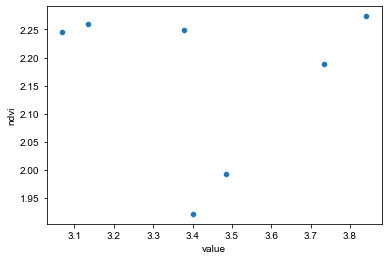

In [54]:
ndviFilePath='/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/pts_seasonalCompositeNDVI_2001-2018_SUM_JFM.gpkg'
startYr = 2012
endYr = 2017


ndvi = gpd.read_file(ndviFilePath)
ndvi = ndvi.rename(columns=dict(zip(list(ndvi.columns[3:21]), list(np.arange(2001, 2019, 1)))))
ndvi = ndvi.drop(columns=['id','geometry'])
ndvi = ndvi.melt(id_vars=["Class", "ADM3_EN"], var_name="Date", value_name='ndvi')
ndvi = ndvi[ndvi.Class=='Rain-fed Rice']
ndvi = ndvi.groupby(['ADM3_EN','Date']).mean().reset_index()

ndvi.ADM3_EN[ndvi.ADM3_EN=='Dueñas']='Duenas'
ndvi.ADM3_EN[ndvi.ADM3_EN=='City of Passi']='Passi City'

ndvi



actual = pd.read_csv('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/iloilo_rice_data_cleaned_imputed_new.csv')
#actual = actual[(actual.param == 'yield') & (actual.ecosystem == 'rf')].reset_index(drop=True)
#actual = actual[(actual.year == 2018)].groupby('muni').mean().reset_index(drop=False)
#actual = actual.groupby('year').mean().reset_index()
#sns.lineplot(x='year', y='value', data=actual)

actual

merged = actual.merge(ndvi, left_on=['year','muni'], right_on=['Date','ADM3_EN'])

merged2=merged.groupby(['muni','ecosystem','value','ndvi']).mean().reset_index()
merged2

df=merged2[(merged2['ecosystem']=='rf')].reset_index(drop=True)
df=df[(df['year']<=endYr) & (df['year']>=startYr)].reset_index(drop=True)
df=df.groupby(['muni']).mean().reset_index()
df

df = df.loc[df['muni'].isin([
'Carles',
'Calinog',
'Estancia',
'Lambunao',
'Cabatuan',
'Duenas',
'Santa Barbara',
'Bingawan',
'Maasin',
'Badiangan'
])]

np.random.seed(1)
df['randnum']=np.random.randint(len(df), size=len(df)).astype(float)
calibration=df[df['randnum']>=(len(df)*0.30)].reset_index(drop=True)
validation=df[df['randnum']<=(len(df)*0.30)].reset_index(drop=True)

sns.scatterplot(x='value', y='ndvi', data = calibration)

results = sm.ols(formula = 'value ~ ndvi', 
                 missing='drop',
                 data=calibration).fit()
print('R^2 = ' + str(results.rsquared.round(decimals=4)))
print('yield = ' + str(results.params[1].round(decimals=4)) + '*NDVI + ' + str(results.params[0].round(decimals=4)))
plt.show()

In [55]:
results_validation = sm.ols(formula = 'value ~ ndvi', 
                 missing='drop',
                 data=validation).fit()
print('R^2 = ' + str(results_validation.rsquared.round(decimals=4)))
print('yield = ' + str(results_validation.params[1].round(decimals=4)) + '*NDVI + ' + str(results_validation.params[0].round(decimals=4)))

R^2 = 0.7049
yield = 3.5785*NDVI + -4.3311
